| | |
| --- | --- |
| **Author** | Pierre Alexander Burger |
| **email** | pburger@uwatelroo.ca |

<div align="center"><img src='https://drive.google.com/uc?id=1KTafFIJzWQTBdtdd6xrI7OszfhpZYkVM' width="400" height="300"></div>

---
---
# **INTRODUCTION**
---
---

This notebook can also be run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eiDX_P0fxcuxv530xr2iceaPbY4CA5pD?usp=sharing)

In this notebook we will train a neural network emulator of 3x2pt of DES Y1, using the ``CosmoPower`` class ``cosmopower_NN``. In particular, we are showing that normlaising the input features is essential. 



---
---
# **PRELIMINARY OPERATIONS** 
---
---

We will start with a few imports, as well as with checking that the notebook is running on a GPU - this is strongly recommended to speed up training.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output

In [2]:
# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
print('using', device, 'device \n')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
using gpu:0 device 



2024-07-16 11:33:57.232099: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-16 11:33:57.232116: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-07-16 11:33:57.232121: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-07-16 11:33:57.232161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-16 11:33:57.232179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


We will also set the random seed, for reproducibility of results. 

In [3]:
# setting the seed for reproducibility
np.random.seed(1)
tf.random.set_seed(2)

---
---
# **TRAINING/TESTING DATA DOWNLOAD**
---
---

Here we will load in the datasets for training and testing our emulator.

For the illustrative purposes of this notebook, we will use datasets of modest size. These are saved in the folder 3times2pt_data.

In [4]:
models = np.load('3times2pt_data/models.npy')
parameters = np.load('3times2pt_data/parameters.npz')
parameters.keys(),models.shape

train_sample = np.arange(0,2000)
test_sample = np.arange(2000,10000)

train_params = {}
for name in parameters.keys():
    train_params[name]=list(np.array(parameters[name])[train_sample])
    
test_params = {}
for name in parameters.keys():
    
    test_params[name]=list(np.array(parameters[name])[test_sample])

train_features = models[train_sample]
test_features = models[test_sample]

Let’s first inspect our input features. As we can see, they vary over a large range of values and have negative values. Therefore, using the log10 of these features is not possible.

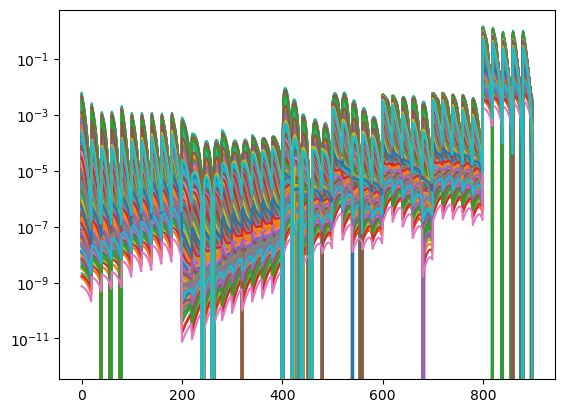

In [5]:
for i in range(2000):
    plt.plot(train_features[i])
plt.yscale('log')

Next, we load in the cosmopower module and train an emulator using 2k features.

In [6]:
from cosmopower_NN import cosmopower_NN

In [7]:
cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [512, 512, 512, 512], # 4 hidden layers, each with 512 nodes
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=train_features,
                filename_saved_model='emulator_wo_scaling',
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different leanring rates
                batch_sizes=[500, 500, 500, 500, 500], # the number for models that are used to adjust the NN parameters
                gradient_accumulation_steps = [1,1,1,1,1],
                patience_values = [100,100,100,100,100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                max_epochs = [1000,1000,1000,1000,1000], # Maxmimal number of epoch before decreasing the learning rate
                )

2024-07-16 10:53:16.100027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-16 10:53:16.100053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[500, 500, 500, 500, 500] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 500


  0%|          | 0/1000 [00:00<?, ?it/s]2024-07-16 10:53:16.465859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 10:53:16.984337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 10:53:17.287797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 22%|██▏       | 218/1000 [00:29<01:46,  7.35it/s, loss=0.00223] 


Validation loss = 0.00082396856
Model saved.
Reached max number of epochs. Validation loss = 0.00082396856
Model saved.
learning rate = 0.001, batch size = 500


 25%|██▌       | 252/1000 [00:33<01:40,  7.42it/s, loss=0.000329]


Validation loss = 0.000136651
Model saved.
Reached max number of epochs. Validation loss = 0.000136651
Model saved.
learning rate = 0.0001, batch size = 500


100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s, loss=5.29e-5]


Reached max number of epochs. Validation loss = 4.7506168e-05
Model saved.
learning rate = 1e-05, batch size = 500


 11%|█         | 107/1000 [00:15<02:05,  7.12it/s, loss=4.57e-5]


Validation loss = 4.4384728e-05
Model saved.
Reached max number of epochs. Validation loss = 4.4384728e-05
Model saved.
learning rate = 1e-06, batch size = 500


 10%|█         | 102/1000 [00:13<02:01,  7.37it/s, loss=4.82e-5]

Validation loss = 4.758109e-05
Model saved.
Reached max number of epochs. Validation loss = 4.758109e-05
Model saved.


Checking the accuracy of the emulator, we observe that its accuracy is not very good.

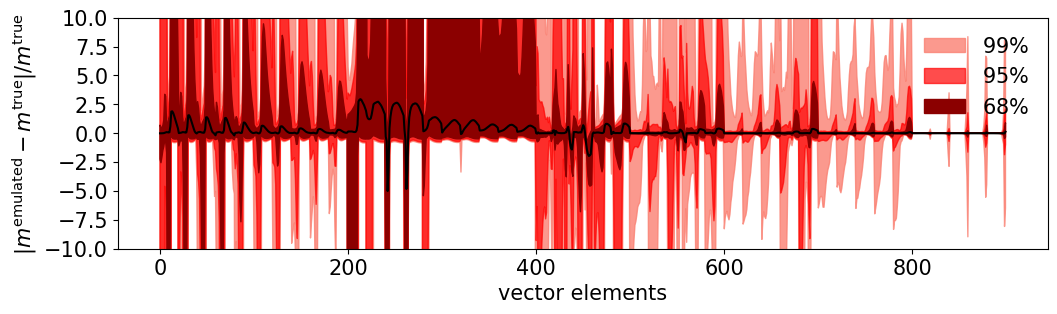

In [8]:
emulated_features = cp_nn.predictions_np(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-10,10)
plt.show()

Now, we train the emulator again, but we rescale the features first by subtracting the mean and dividing by its standard deviation.

In [9]:
#These premodifications are not necessary but might improve the accuracy
scale_subtraction=np.mean(train_features,axis=0)
scale_division=np.std(train_features,axis=0)

features_modified=(train_features-scale_subtraction)/scale_division

cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [512, 512, 512, 512], # 4 hidden layers, each with 512 nodes
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=features_modified,
                filename_saved_model='emulator_w_scaling',
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different leanring rates
                batch_sizes=[500, 500, 500, 500, 500], # the number for models that are used to adjust the NN parameters
                gradient_accumulation_steps = [1,1,1,1,1],
                patience_values = [100,100,100,100,100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                max_epochs = [1000,1000,1000,1000,1000], # Maxmimal number of epoch before decreasing the learning rate
                )


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[500, 500, 500, 500, 500] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 500


  0%|          | 0/1000 [00:00<?, ?it/s]2024-07-16 10:57:01.324034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 10:57:01.742332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 10:57:02.006854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 35%|███▌      | 354/1000 [00:48<01:28,  7.30it/s, loss=0.0463]


Validation loss = 0.019589363
Model saved.
Reached max number of epochs. Validation loss = 0.019589363
Model saved.
learning rate = 0.001, batch size = 500


 36%|███▌      | 361/1000 [00:47<01:24,  7.53it/s, loss=0.00834]


Validation loss = 0.0033027523
Model saved.
Reached max number of epochs. Validation loss = 0.0033027523
Model saved.
learning rate = 0.0001, batch size = 500


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s, loss=0.00111]


Reached max number of epochs. Validation loss = 0.0011131855
Model saved.
learning rate = 1e-05, batch size = 500


 10%|█         | 101/1000 [00:13<01:56,  7.72it/s, loss=0.00119]


Validation loss = 0.001153853
Model saved.
Reached max number of epochs. Validation loss = 0.001153853
Model saved.
learning rate = 1e-06, batch size = 500


 10%|█         | 100/1000 [00:12<01:56,  7.74it/s, loss=0.000989]

Validation loss = 0.00096963526
Model saved.
Reached max number of epochs. Validation loss = 0.00096963526
Model saved.


As we can see, the scaling significantly improves the accuracy of the emulator. However, we need to know the values that are used to scale the features in order to rescale them.

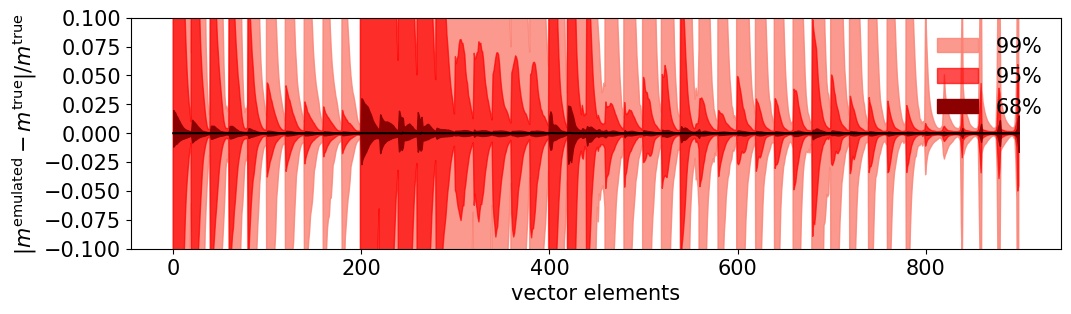

In [10]:
emulated_features = cp_nn.predictions_np(test_params)
emulated_features = emulated_features*scale_division+scale_subtraction # convert back to original data vectors

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()

Lastly, we use cosmopower_NN’s built-in scaling instead of rescaling by hand in a previous step.

In [11]:
#These premodifications are not necessary but might improve the accuracy
processing_vectors = {'mean':np.mean(train_features,axis=0), 'sigma':np.std(train_features,axis=0)}

def preprocessing(features,processing_vectors):
    return (features-processing_vectors['mean'])/processing_vectors['sigma']

def postprocessing_np(features,processing_vectors):
    return features*processing_vectors['sigma'] + processing_vectors['mean']

def postprocessing_tf(features,processing_vectors):
    return tf.add(tf.multiply(features, processing_vectors['sigma']), processing_vectors['mean'])


cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [512, 512, 512, 512], # 4 hidden layers, each with 512 nodes
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=train_features,
                filename_saved_model='emulator_w_scaling_internally',
                preprocessing = preprocessing,
                postprocessing_np = postprocessing_np,
                postprocessing_tf = postprocessing_tf,
                processing_vectors = processing_vectors,
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different leanring rates
                batch_sizes=[500, 500, 500, 500, 500], # the number for models that are used to adjust the NN parameters
                gradient_accumulation_steps = [1,1,1,1,1],
                patience_values = [100,100,100,100,100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                max_epochs = [1000,1000,1000,1000,1000], # Maxmimal number of epoch before decreasing the learning rate
                )


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[500, 500, 500, 500, 500] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 500


  0%|          | 0/1000 [00:00<?, ?it/s]2024-07-16 11:01:17.721652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 11:01:18.196711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 11:01:18.474006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 46%|████▌     | 461/1000 [01:04<01:15,  7.14it/s, loss=0.0512]


Validation loss = 0.014633567
Model saved.
Reached max number of epochs. Validation loss = 0.014633567
Model saved.
learning rate = 0.001, batch size = 500


 31%|███▏      | 313/1000 [00:40<01:29,  7.67it/s, loss=0.00416]


Validation loss = 0.00260735
Model saved.
Reached max number of epochs. Validation loss = 0.00260735
Model saved.
learning rate = 0.0001, batch size = 500


 11%|█▏        | 114/1000 [00:14<01:56,  7.63it/s, loss=0.00182]


Validation loss = 0.0017733104
Model saved.
Reached max number of epochs. Validation loss = 0.0017733104
Model saved.
learning rate = 1e-05, batch size = 500


 10%|█         | 100/1000 [00:13<01:58,  7.61it/s, loss=0.00164]


Validation loss = 0.0016055113
Model saved.
Reached max number of epochs. Validation loss = 0.0016055113
Model saved.
learning rate = 1e-06, batch size = 500


 10%|█         | 100/1000 [00:14<02:07,  7.03it/s, loss=0.00168]

Validation loss = 0.0016415262
Model saved.
Reached max number of epochs. Validation loss = 0.0016415262
Model saved.


As we can see, the accuracy is as good as when we scaled the features by hand in a previous step. However, with the built-in scaling in cosmopower_NN, we do not need to remember how the features are rescaled.

In [12]:
list(processing_vectors.keys())

['mean', 'sigma']

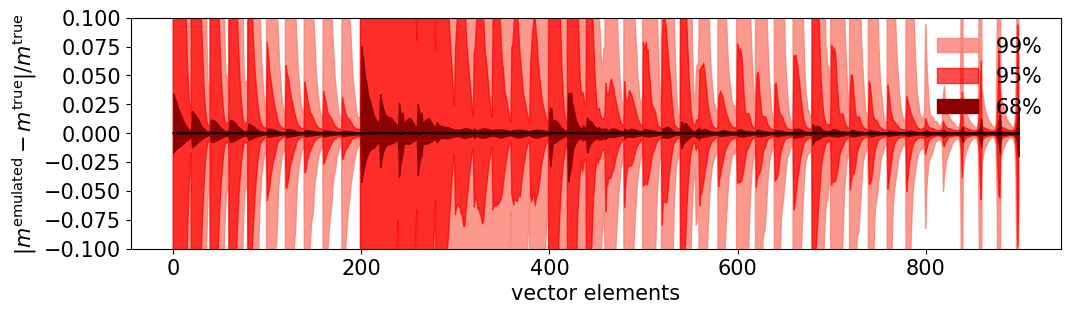

In [13]:
emulated_features = cp_nn.rescaled_predictions_np(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()

In [14]:
#These premodifications are not necessary but might improve the accuracy


cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [512, 512, 512, 512], # 4 hidden layers, each with 512 nodes
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=train_features,
                filename_saved_model='emulator_w_scaling_internally',
                preprocessing = 'mean_sigma',
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different leanring rates
                batch_sizes=[500, 500, 500, 500, 500], # the number for models that are used to adjust the NN parameters
                gradient_accumulation_steps = [1,1,1,1,1],
                patience_values = [100,100,100,100,100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                max_epochs = [1000,1000,1000,1000,1000], # Maxmimal number of epoch before decreasing the learning rate
                )


Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[500, 500, 500, 500, 500] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

{'mean': array([ 4.70998498e-04,  3.89745800e-04,  3.17232817e-04,  2.53693864e-04,
        1.99079866e-04,  1.53088215e-04,  1.15203522e-04,  8.47218335e-05,
        6.08012271e-05,  4.25189162e-05,  2.89293466e-05,  1.91189374e-05,
        1.22509647e-05,  7.59634381e-06,  4.54857552e-06,  2.62469872e-06,
        1.45631722e-06,  7.74759275e-07,  3.93308418e-07,  1.88643484e-07,
        2.06315896e-04,  1.72969224e-04,  1.42582291e-04,  1.15393544e-04,
        9.15418977e-05,  7.10631767e-

  0%|          | 0/1000 [00:00<?, ?it/s]2024-07-16 11:03:46.811616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 11:03:47.275700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 11:03:47.544893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 29%|██▉       | 289/1000 [00:39<01:37,  7.27it/s, loss=0.039] 


Validation loss = 0.024333552
Model saved.
Reached max number of epochs. Validation loss = 0.024333552
Model saved.
learning rate = 0.001, batch size = 500


 25%|██▍       | 246/1000 [00:32<01:39,  7.58it/s, loss=0.00494]


Validation loss = 0.003308611
Model saved.
Reached max number of epochs. Validation loss = 0.003308611
Model saved.
learning rate = 0.0001, batch size = 500


100%|██████████| 1000/1000 [02:09<00:00,  7.69it/s, loss=0.00129]


Reached max number of epochs. Validation loss = 0.0012774027
Model saved.
learning rate = 1e-05, batch size = 500


 10%|█         | 102/1000 [00:12<01:54,  7.86it/s, loss=0.00117]


Validation loss = 0.0011431216
Model saved.
Reached max number of epochs. Validation loss = 0.0011431216
Model saved.
learning rate = 1e-06, batch size = 500


 10%|█         | 101/1000 [00:12<01:55,  7.81it/s, loss=0.00108]

Validation loss = 0.0010423596
Model saved.
Reached max number of epochs. Validation loss = 0.0010423596
Model saved.


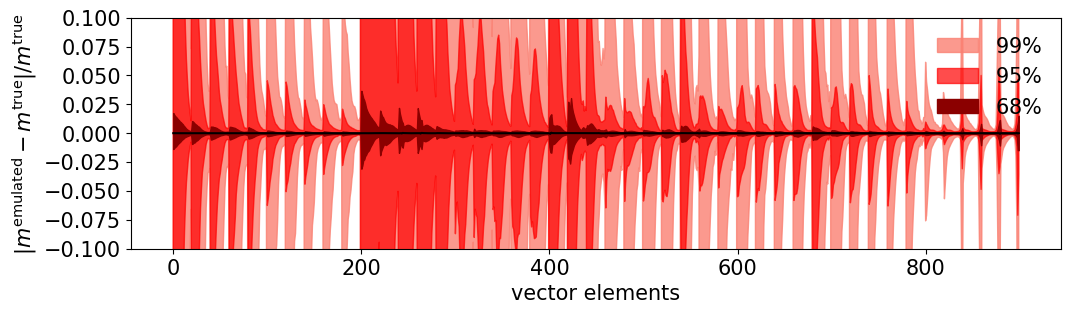

In [15]:
emulated_features = cp_nn.rescaled_predictions_np(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()

In [8]:
#These premodifications are not necessary but might improve the accuracy


cp_nn = cosmopower_NN(parameters=list(parameters.keys()), 
                    modes=np.linspace(-1,1,train_features.shape[1]), 
                    n_hidden = [512, 512, 512, 512], # 4 hidden layers, each with 512 nodes
                    verbose=True, # useful to understand the different steps in initialisation and training
                    )

with tf.device(device):
    # train
    cp_nn.train(training_parameters=train_params,
                training_features=train_features,
                filename_saved_model='emulator_w_scaling_internally',
                preprocessing = 'min_max',
                # cooling schedule
                validation_split=0.1, # The precentage from train sample that is used for the validation
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6], # the different leanring rates
                batch_sizes=[500, 500, 500, 500, 500], # the number for models that are used to adjust the NN parameters
                gradient_accumulation_steps = [1,1,1,1,1],
                patience_values = [100,100,100,100,100], # Number of epoch to wait before decreasing the learning rate if the loss does not improve anymore
                max_epochs = [1000,1000,1000,1000,1000], # Maxmimal number of epoch before decreasing the learning rate
                )

2024-07-16 11:34:19.489061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-16 11:34:19.489087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Initialized cosmopower_NN model, 
mapping 4 input parameters to 900 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[500, 500, 500, 500, 500] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[100, 100, 100, 100, 100] patience values 
[1000, 1000, 1000, 1000, 1000] max epochs 

learning rate = 0.01, batch size = 500


  0%|          | 0/1000 [00:00<?, ?it/s]2024-07-16 11:34:19.998738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 11:34:20.534982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-16 11:34:20.838146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 51%|█████     | 511/1000 [01:07<01:04,  7.60it/s, loss=0.00823]


Validation loss = 0.0028484198
Model saved.
Reached max number of epochs. Validation loss = 0.0028484198
Model saved.
learning rate = 0.001, batch size = 500


 32%|███▏      | 319/1000 [00:41<01:28,  7.70it/s, loss=0.000791]


Validation loss = 0.0005429524
Model saved.
Reached max number of epochs. Validation loss = 0.0005429524
Model saved.
learning rate = 0.0001, batch size = 500


100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s, loss=0.000241]


Reached max number of epochs. Validation loss = 0.00023011779
Model saved.
learning rate = 1e-05, batch size = 500


 10%|█         | 100/1000 [00:12<01:56,  7.70it/s, loss=0.000206]


Validation loss = 0.0001988464
Model saved.
Reached max number of epochs. Validation loss = 0.0001988464
Model saved.
learning rate = 1e-06, batch size = 500


 10%|█         | 100/1000 [00:13<02:01,  7.38it/s, loss=0.000219]

Validation loss = 0.00021344092
Model saved.
Reached max number of epochs. Validation loss = 0.00021344092
Model saved.


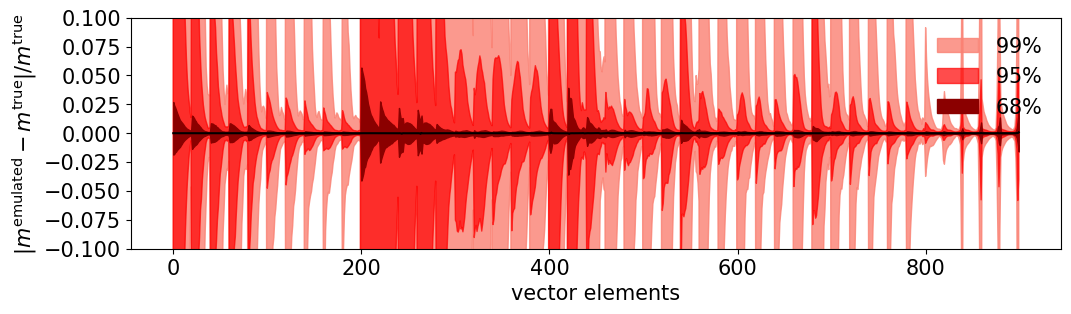

In [9]:
emulated_features = cp_nn.rescaled_predictions_np(test_params)

diff=(emulated_features/test_features-1) # Measure the relative difference between test sample and the emualted models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = '$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = '$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = '$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.ylabel(r'$| m^{\mathrm{emulated}} - m^{\mathrm{true}}|/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()